# INTRODUCTION TO DEEP LEARNING: FINAL PROJECT

# **CETACEAN IMAGE CLASSIFICATION**

# **Introduction**

This project is about developing a machine learning model for image classification, with a focus on identifying cetacean species from a dataset of photographs portraying their dorsal fin or their tail. The dataset consists of images taken by enthusiasts during whale watching activities, making it a real-world challenge with diverse and non-standardized inputs. The task is a supervised learning problem, specifically a multi-class classification, where the objective is to accurately classify images into different cetacean species using Deep Learning techniques.

The goal of this project is to apply my data science skills to a subject I am passionate about—natural and environmental issues, giving me the opportunity to explore how my knowledge can be used in contexts that I care deeply about. This project represents a step toward what I hope to pursue in my future professional life: using data science to address issues in nature and the environment.

To perform this classification I will use three different ML models that we learned in this course: a simple CNN model, a CNN implementing Transfer Learning and, at the end, a more classic GradientBoosting Classifier.

Let's begin by importing the dataset and all the required libraries.

In [ ]:
! ls -lha kaggle.json
! pip install -q kaggle # installing the kaggle package
! mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
! cp kaggle.json ~/.kaggle/ # move the key to the folder
! pwd # checking the present working directory
! chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 62 Jul 25 15:03 kaggle.json
/content


In [ ]:
! kaggle datasets download -d andrewgustyjrstudent/happywhaleimagessortedbyspecies -p /content/input_data/cetacean_classification

Dataset URL: https://www.kaggle.com/datasets/andrewgustyjrstudent/happywhaleimagessortedbyspecies
License(s): CC0-1.0
 99% 1.43G/1.45G [00:07<00:00, 164MB/s]
100% 1.45G/1.45G [00:07<00:00, 206MB/s]


In [ ]:
! ls -l input_data/cetacean_classification/happywhaleimagessortedbyspecies.zip

-rw-r--r-- 1 root root 1552669540 Mar 26  2022 input_data/cetacean_classification/happywhaleimagessortedbyspecies.zip


In [ ]:
! unzip input_data/cetacean_classification/happywhaleimagessortedbyspecies.zip -d input_data/cetacean_classification/

Output streaming troncato alle ultime 5000 righe.
  inflating: input_data/cetacean_classification/train_species_list/minke_whale/c4368307947d96.jpg  
  inflating: input_data/cetacean_classification/train_species_list/minke_whale/c436988522e3ad.jpg  
  inflating: input_data/cetacean_classification/train_species_list/minke_whale/c4480e4ff0ae4e.jpg  
  inflating: input_data/cetacean_classification/train_species_list/minke_whale/c48628e883112f.jpg  
  inflating: input_data/cetacean_classification/train_species_list/minke_whale/c486ccf0a8f4a8.jpg  
  inflating: input_data/cetacean_classification/train_species_list/minke_whale/c4bcb5b0f64a02.jpg  
  inflating: input_data/cetacean_classification/train_species_list/minke_whale/c4da3d4e7c574c.jpg  
  inflating: input_data/cetacean_classification/train_species_list/minke_whale/c5124fceabc054.jpg  
  inflating: input_data/cetacean_classification/train_species_list/minke_whale/c518836e7556ba.jpg  
  inflating: input_data/cetacean_classification/tr

In [ ]:
! pip install pandas numpy matplotlib seaborn scikit-learn

In [ ]:
# Importing libraries
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from PIL import Image
from skimage.measure import shannon_entropy
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import random as rnd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2

# **DATA DESCRIPTION AND DATA CLEANING**

The dataset I am using for this project is sourced from Kaggle and is titled "Happy Whale Images Sorted By Species" (https://www.kaggle.com/datasets/andrewgustyjrstudent/happywhaleimagessortedbyspecies?select=train_species_list). The data is 1.55 GB in size and consists of 30 directories, each representing a different cetacean species. All the images are in JPG format and are in color, providing rich visual information for training the classification models.

Before performing any data cleaning on my dataset, I want to first check how many photos are contained in each of my folders. This step helpes me understand the distribution of images across different cetacean species. Knowing the number of photos in each folder is crucial for deciding the best approach to proceed with my analysis, as it informs me about the balance of the dataset and potential issues related to class imbalance.

In [ ]:
# Create a dict to count the images I have for each species, then show a histogram
species_count = {
    'beluga': 0,
    'blue_whale': 0,
    'bottlenose_dolphin': 0,
    'bottlenose_dolpin': 0,
    'brydes_whale': 0,
    'commersons_dolphin': 0,
    'common_dolphin': 0,
    'cuviers_beaked_whale': 0,
    'dusky_dolphin': 0,
    'false_killer_whale': 0,
    'fin_whale': 0,
    'frasiers_dolphin': 0,
    'globis': 0,
    'gray_whale': 0,
    'humpback_whale': 0,
    'kiler_whale': 0,
    'killer_whale': 0,
    'long_finned_pilot_whale': 0,
    'melon_headed_whale': 0,
    'minke_whale': 0,
    'pantropic_spotted_dolphin': 0,
    'pilot_whale': 0,
    'pygmy_killer_whale': 0,
    'rough_toothed_dolphin': 0,
    'sei_whale': 0,
    'short_finned_pilot_whale': 0,
    'southern_right_whale': 0,
    'spinner_dolphin': 0,
    'spotted_dolphin': 0,
    'white_sided_dolphin': 0
}

for dirname, _, filenames in os.walk('/content/input_data/cetacean_classification/train_species_list'):
    for filename in filenames:
        species_name = dirname[dirname.rindex('/')+1:]
        species_count[species_name] += 1

print(species_count)

{'beluga': 7443, 'blue_whale': 4830, 'bottlenose_dolphin': 9664, 'bottlenose_dolpin': 1117, 'brydes_whale': 154, 'commersons_dolphin': 90, 'common_dolphin': 347, 'cuviers_beaked_whale': 341, 'dusky_dolphin': 3139, 'false_killer_whale': 3326, 'fin_whale': 1324, 'frasiers_dolphin': 14, 'globis': 116, 'gray_whale': 1123, 'humpback_whale': 7392, 'kiler_whale': 962, 'killer_whale': 1493, 'long_finned_pilot_whale': 238, 'melon_headed_whale': 1689, 'minke_whale': 1608, 'pantropic_spotted_dolphin': 145, 'pilot_whale': 262, 'pygmy_killer_whale': 76, 'rough_toothed_dolphin': 60, 'sei_whale': 428, 'short_finned_pilot_whale': 367, 'southern_right_whale': 866, 'spinner_dolphin': 1700, 'spotted_dolphin': 490, 'white_sided_dolphin': 229}


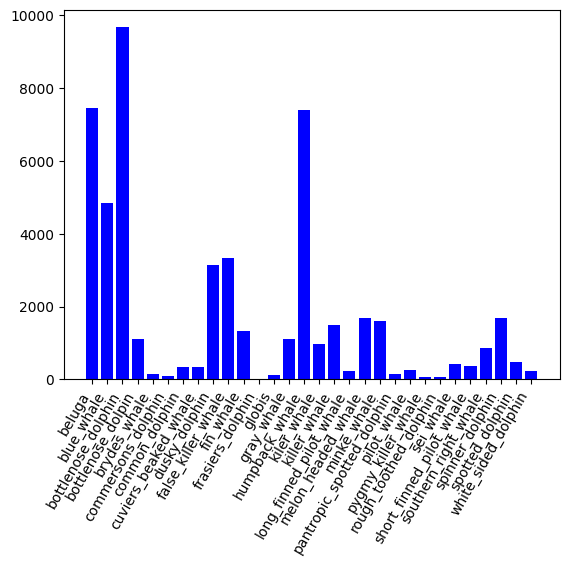

In [ ]:
plt.bar(list(species_count.keys()), species_count.values(), color='b')
plt.xticks(rotation=60, ha='right')
plt.show()

As shown by the histogram, we can see the data is extremely unbalanced: a few folders contain thousands of photos, while most of them contain only hundreds. To prevent problems arising from unbalanced data as well as inconclusive results due to lack of data, and for computational capacity reasons,  I decide to focus on the top three folders, which contain the majority of my images. By limiting my analysis to these folders, I aim to achieve more accurate and meaningful results.

At this stage, I extract images from the 'beluga'(7443), 'humpback whale'(7392), and 'bottlenose dolphin'(9664) directories. In order to ensure equal representation from each category, I want to perform a little undersampling to reduce the number of images to 7350 per species. I achieve this by selecting the first 7350 photos from each folder, legitimately assuming that this collection of non-organized and not ordered images holds a built-in randomness. Under this assumptions, we can fairly get rid of folders where the name of species is clearly misspelled, like "bottlenose_dolpin" or "kiler_whale".<br>
Finally, I convert each JPG file into an array of pixels and transform them to RGB format. I then compile all these images into a newly created list, preparing the data for subsequent analysis and model training.

In [ ]:
# Create a list of my image data + undersampling 7350
species = ["beluga","humpback_whale","bottlenose_dolphin"]
photo_list = []
for dirname, _, filenames in os.walk('/content/input_data/cetacean_classification/train_species_list'):
    count = 0
    for filename in filenames:
        if count < 7350:
            if dirname[dirname.rindex('/')+1:] in species:
                img_path = os.path.join(dirname, filename)  # re-build all the path to image file
                img = cv2.imread(img_path)                  # here cv2 transforms the file (jpg) in an nparray
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                photo_list.append(img)
                count += 1

print(len(photo_list))

22050


Here is a sample of the final images I am going to use in my analysis. Specifically, the grid below displays a random sample of images from my dataset which helps to get a sense of the variety and quality of the images.

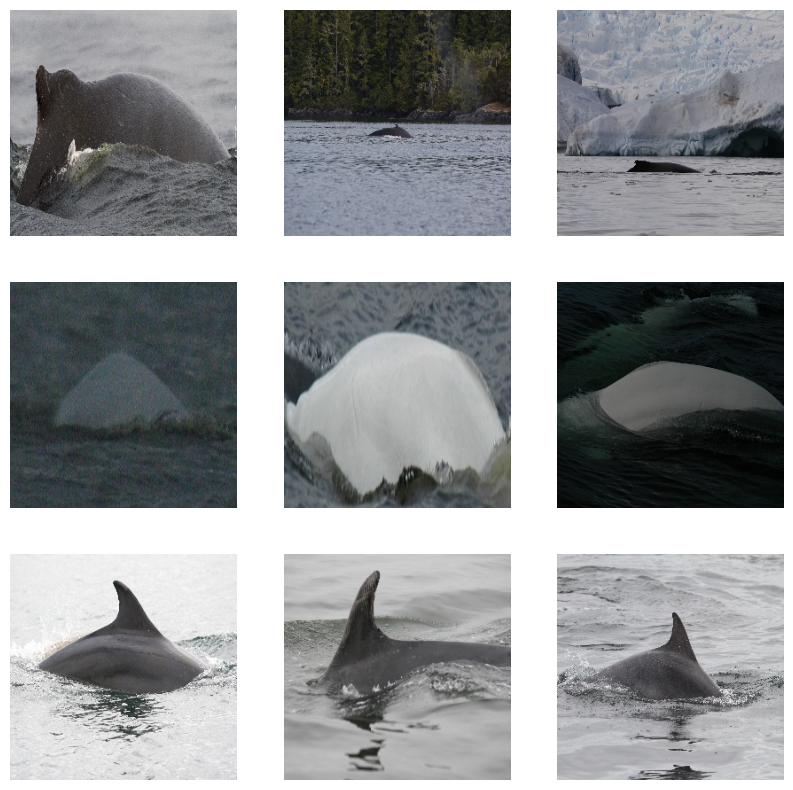

In [ ]:
# Visualizing Sample Images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # setup plot grid: 3x3 grid of 10x10 pics (subplots)
for i, ax in enumerate(axes.flat):                # for each row and for each col in the 3x3 grid
    ax.imshow(photo_list[rnd.randint(7350*(i/3),7350*((i+1)/3))], cmap='gray')         # show i-th image (nparray) of list photo_list. ax element is an axis (from matplotlib)
    ax.axis('off')                                # dont show axis in each subplot
plt.show()


As the last step, it is important to verify that all the images have the same size. The two following histograms show the distribution of image sizes both for width and for height, indicating all images are 256x256 pixels.

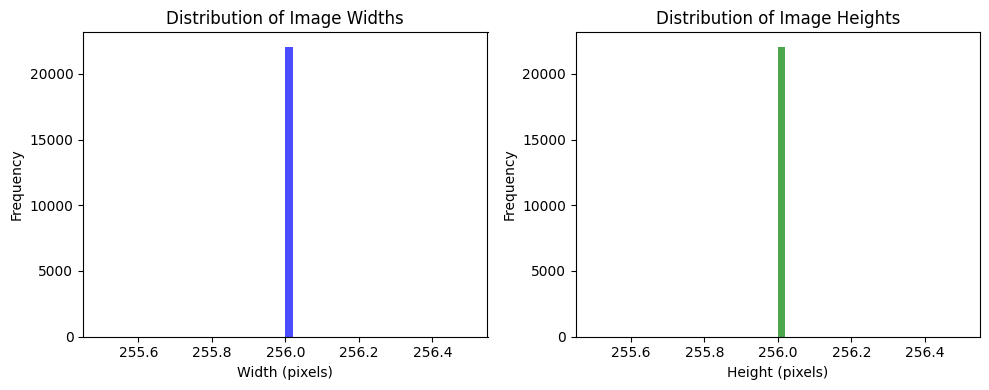

In [ ]:
# Image Size and Aspect Ratio
# Size Distribution: Plot the distribution of image sizes (width and height).

widths = [image.shape[1] for image in photo_list]
heights = [image.shape[0] for image in photo_list]

plt.figure(figsize=(10, 4))

# Histogram for image widths
plt.subplot(1, 2, 1)
plt.hist(widths, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Histogram for image heights
plt.subplot(1, 2, 2)
plt.hist(heights, bins=50, color='green', alpha=0.7)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# **EXPLORATORY DATA ANALYSIS**

Performing an exploratory data analysis on data is crucial since it helps to fully understand the inner aspects of the dataset. In my EDA, I will perform several analysis on the selected images, including aspects such as distribution of pixel values, average intensity of the images, color distribution, contrast and entropy. First thing to do is to convert the list of photos created above in a numpy array.

In [ ]:
np_photo_list = np.array(photo_list)  # convert photo_list in a nparray

**PIXEL VALUE DISTRIBUTION**

This analysis helps identify the range and frequency of pixel values across images in the cleaned dataset. Understanding pixel value distribution is crucial for preprocessing steps and for identifying any anomalies or outliers in the image data. Here I plotted a histogram that shows their distribution.

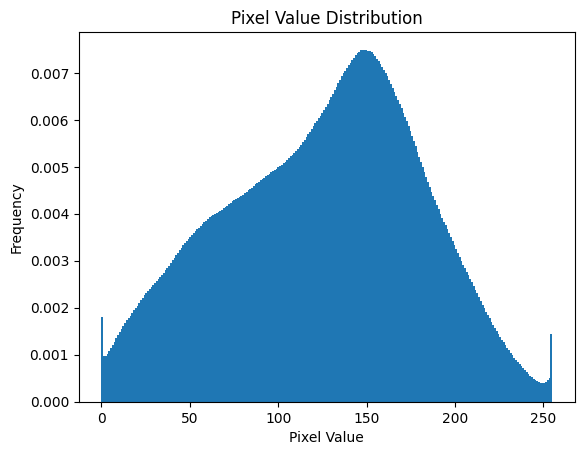

In [ ]:
# Pixel Value Distribution
pixel_values = np_photo_list.flatten()
plt.hist(pixel_values, bins=256, range=(0, 255), density=True) # density True is the freq normalized to 1 (i.e. in a probabilistic sense)
                                                               # density False is the absolute frequency, so a classic histogram
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

As said above, the chart illustrates the distribution of pixel values across photos in the dataset belonging to the three selected species. The x-axis represents the pixel values ranging from 0 to 255, where 0 is black, 255 is white. The y-axis shows the frequency of these pixel values, normalized to a maximum of 1. The distribution indicates that the pixel values are spread across the entire range, with a higher concentration between approximately 100 and 200.<br>
This suggests that the photos predominantly contain mid-range pixel values, resulting in images that are neither too dark nor too bright. The peak around 150 suggests that most of them are in this mid-tone range, which might be due to the nature of the cetacean images and their oceanic environment. Additionally, there are smaller frequencies at the extreme ends (near 0 and 255), indicating the presence of some very dark and very bright pixels.

**AVERAGE INTENSITY OF THE IMAGES**

By examining the average intensity of the images, it is possible to assess the overall brightness levels within the dataset. This information is useful for detecting any images that are too dark or too bright, which may need adjustment to ensure uniformity.

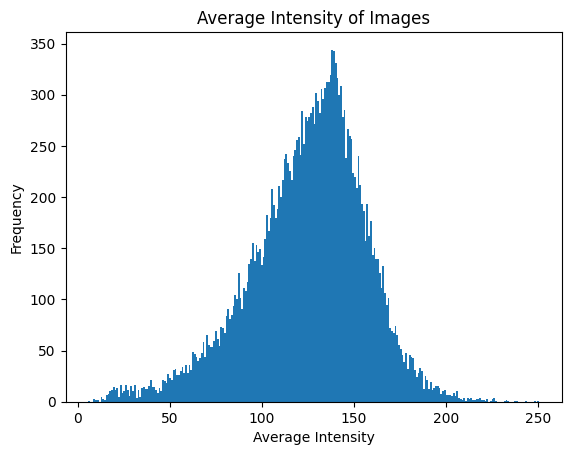

In [ ]:
# Image Intensity
avg_intensity = [np.mean(image) for image in np_photo_list]  # computes the mean value of each single img in np_photo_list
plt.hist(avg_intensity, bins=256)
plt.title('Average Intensity of Images')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.show()

The chart presents the distribution of average intensity values for the images in the dataset. As in the previous histogram, the x-axis represents the average intensity values, ranging from 0 to 255, where 0 is black, 255 is white. The y-axis shows the frequency of these average intensity values.<br>
The distribution is roughly bell-shaped, peaking around an average intensity value of approximately 130-140. This indicates that most images have a mid-range average intensity, confirming that they are neither too dark nor too bright overall. The symmetrical shape of the distribution suggests that the dataset contains a balanced variety of images in terms of brightness.<br>
There are fewer images with extremely low or high average intensity values, as evidenced by the lower frequencies towards the ends of the x-axis. This means that very dark or very bright images are less common in the dataset.

**RGB COLOR DISTRIBUTION**

Analyzing the distribution of colors (red, green, and blue channels) provides insight into the color balance and composition of the images. This can help understand the visual characteristics of the dataset and can theoretically inform color-related preprocessing steps, such as color normalization or augmentation. <br>
The next three histograms display the distribution of pixel values for the red, green, and blue color channels across all the photos in the dataset. Each plot provides insight into how frequently each pixel value (ranging from 0 to 255) occurs in each color channel.

In [ ]:
max_frequency = 0

# Calculate the maximum frequency across all channels
for i, (color, channel) in enumerate(zip(['Red', 'Green', 'Blue'], range(3))):
    color_values = np_photo_list[:, :, :, channel].flatten()
    hist, bins = np.histogram(color_values, bins=256)
    max_frequency = max(max_frequency, max(hist))

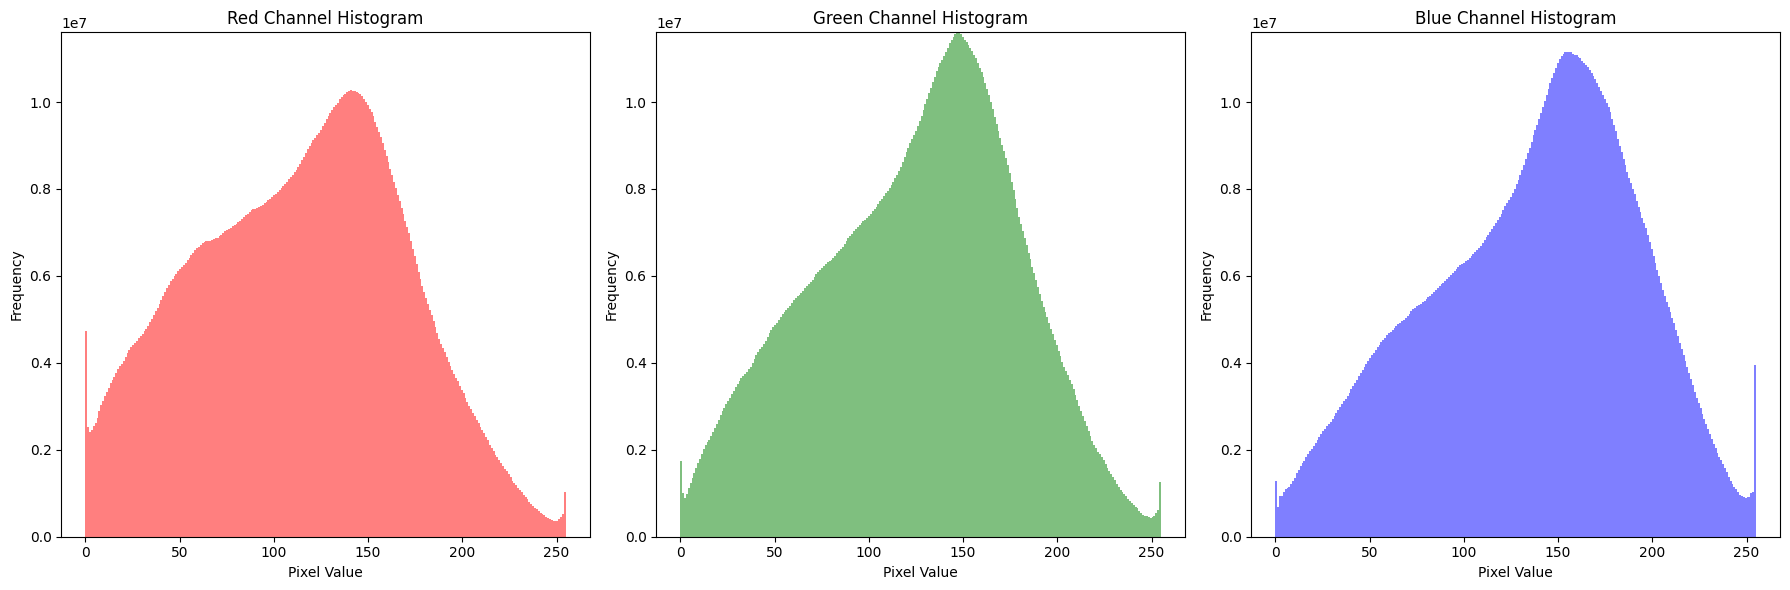

In [ ]:
# Plot histograms with a consistent y-axis scale

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,6))

for i, (color, channel) in enumerate(zip(['Red', 'Green', 'Blue'], range(3))):
    plt.subplot(1, 3, i+1)
    color_values = np_photo_list[:, :, :, channel].flatten()
    plt.hist(color_values, bins=256, alpha=0.5, color=color.lower())
    plt.title(f'{color} Channel Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.ylim(0, max_frequency)  # Set the y-axis limit to the maximum frequency

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

All three histograms show that the pixel values in each color channel are predominantly within the mid-range (approximately 100-200), indicating that the images have a balanced distribution of color intensities without extreme dark or bright areas. The peaks in each histogram around the mid-tone values suggest that the images have a natural and well-balanced color distribution, which is typical for photographs taken in natural environments. The similarity in the shape of the distributions across the three channels indicates that the images are well-balanced in terms of color, without any single channel dominating the color composition.

**ENTROPY AND CONTRAST**

Entropy measures the randomness or complexity within the images. High entropy values indicate more detailed and complex images, while low entropy values suggest simpler images with less variation. This analysis helps in understanding the diversity and texture of the dataset, which can influence feature extraction and model performance.<br>
Measuring the contrast in images helps determine the difference in luminance or color that makes objects distinguishable. High contrast can indicate clear and distinct features, while low contrast may suggest the need for enhancement techniques to improve feature visibility.

In [ ]:
# Compute contrast from image
def compute_contrast(pic):
    try:
        #img = pic.convert('RGB')
        gray_img = rgb2gray(np.array(pic))
        # Compute GLCM
        glcm = graycomatrix((gray_img * 255).astype(np.uint8), distances=[1], angles=[0], symmetric=True, normed=True)
        # Extract contrast
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        return contrast
    except Exception as e:
        print(f"Error processing image {pic}: {e}")
        return None

contrasts = []
for el in np_photo_list:
    contrast = compute_contrast(el)
    if contrast is not None:
        contrasts.append(contrast)

*NOTE: the following cell may take a long time to complete execution*

In [ ]:
# Compute entropy
entropies = [shannon_entropy(image) for image in np_photo_list]

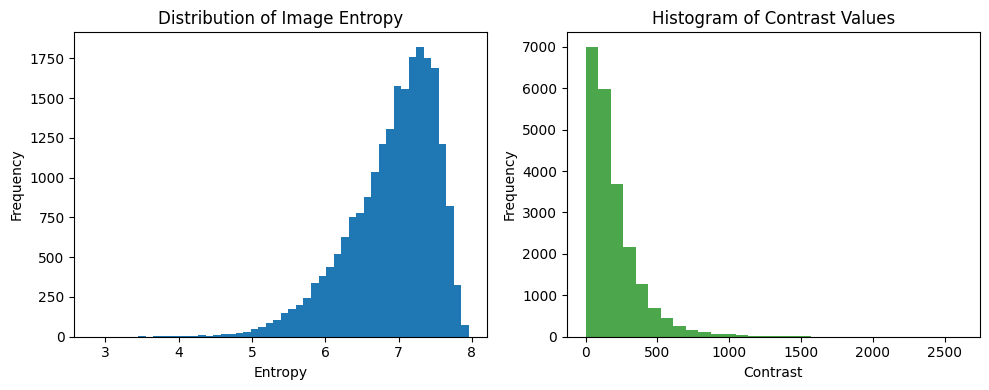

In [ ]:
plt.figure(figsize=(10, 4))

# Plot histogram of entropy values
plt.subplot(1, 2, 1)
plt.hist(entropies, bins=50)
plt.title('Distribution of Image Entropy')
plt.xlabel('Entropy')
plt.ylabel('Frequency')

# Plot histogram of contrast values
plt.subplot(1, 2, 2)
plt.hist(contrasts, bins=30, color='green', alpha=0.7)
plt.title('Histogram of Contrast Values')
plt.xlabel('Contrast')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The left plot shows the distribution of image entropy across all images in the dataset. High entropy values indicate more complexity and variety in the pixel values, which usually correspond to more detailed or textured images.<br>
Most images have entropy values between 5 and 7, with a peak around 6.5 to 7. The distribution is left-skewed, meaning there are fewer images with lower entropy values and a gradual increase in the number of images as entropy increases.<br>
This suggests that most images in the dataset have a moderate to high level of detail and complexity. The fewer low-entropy images might be simpler or less detailed, which is less common in the dataset.

The right-hand-side chart depicts the histogram of contrast values across all images. Contrast refers to the difference in luminance or color that makes an object distinguishable from other objects within the same field of view.<br>
The contrast values range from 0 to about 2500. The majority of images have contrast values below 500, with a significant peak at lower contrast values. The distribution is highly right-skewed, with a very large number of images having low contrast values (close to 0) and progressively fewer images as contrast values increase.<br>
This suggests that many images in the dataset have low contrast, indicating that they may have less differentiation in luminance or color within the image.

In conclusion, the moderate to high entropy values indicate that the dataset contains a variety of detailed images, which is beneficial for training robust machine learning models.
The prevalence of low-contrast images might indicate that many images have subtle differences in pixel values, which could be challenging for certain types of image recognition tasks.

**EDA CONCLUSIONS**

Overall, the dataset appears to be quite rich and diverse, capturing a wide range of visual features including varying brightness levels, color distributions, textures, and contrasts. The balance in color channels and the normal distribution of average intensity values indicate that the images are natural and not artificially manipulated, which is crucial for developing models that perform well on real-world data.<br>
On the other hand, the variability in contrast and intensity suggests that some images might be of lower quality or taken in non-optimal conditions. Think about photos taken from a moving boat, other with sunlight direclty in front of camera or simply blurred images.

# **ANALYSIS AND EVALUATION**

In this section, I present the results of the image classification task using three distinct models that represent increasing levels of complexity and learning power:

- A **Simple Convolutional Neural Network (CNN)** built from scratch
- A **Transfer Learning-based CNN** using a pre-trained MobileNetV2 model
- A **Gradient Boosting Classifier** trained on handcrafted image features

Each model was evaluated on the same dataset of cetacean images, ensuring comparability across metrics such as accuracy, precision, recall, and F1-score.

While collinearity is a common concern in traditional tabular data, it manifests differently in images. In the case of image data, adjacent pixels are naturally correlated due to spatial continuity, which CNNs are specifically designed to exploit through the use of filters and receptive fields.


# **1. SIMPLE CNN**

The first approach consists of building a basic CNN architecture from scratch, using TensorFlow and Keras. The goal is to evaluate how well a relatively shallow network can perform on this image classification task without relying on external knowledge or pre-trained weights.

The pipeline includes:

1. Loading raw .jpg images from their respective class folders.
2. Converting images into NumPy arrays to extract pixel-level data.
3. Preparing a TensorFlow dataset suitable for training and validation.
4. Designing and training a CNN with a small number of convolutional and pooling layers followed by dense layers.

This serves as a baseline model for comparison with more advanced approaches.

In [ ]:
# Image parameters
IMG_SIZE = 128  # resize to smaller size to speed up training
root_dir = '/content/input_data/cetacean_classification/train_species_list'
class_names = ["beluga", "humpback_whale", "bottlenose_dolphin"]
label_map = {name: i for i, name in enumerate(class_names)}

In [ ]:
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    count = 0
    for filename in os.listdir(folder_path):
      if count < 7350:
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0  # normalize
            images.append(img)
            labels.append(label)
            count += 1

    return images, labels

In [ ]:
X = []
y = []

for species in class_names:
    folder = os.path.join(root_dir, species)
    images, labels = load_images_from_folder(folder, label_map[species])
    X.extend(images)
    y.extend(labels)

In [ ]:
# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)
print("Dataset shape:", X.shape, y.shape)

Dataset shape: (24499, 128, 128, 3) (24499,)


### Train/Test Split and One-hot Encoding

The dataset is split into training and testing subsets to evaluate generalization. Labels are encoded using one-hot encoding, which is standard in multi-class classification problems. This transformation allows the model to output a probability distribution over all possible classes, aligning with the categorical cross-entropy loss function used during training.


In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

### CNN Building

The CNN model is composed of a series of convolutional layers with ReLU activation functions, interleaved with max-pooling layers to reduce spatial dimensions and capture hierarchical features. The output of the final convolutional block is flattened and passed through dense layers, with a softmax output layer for multi-class classification.

The model is compiled using the Adam optimizer and categorical cross-entropy loss, both well-suited for this type of problem. I tracked accuracy as the primary evaluation metric.


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train_cat, epochs=20, validation_data=(X_test, y_test_cat))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7275 - loss: 0.6075 - val_accuracy: 0.8812 - val_loss: 0.3043
Epoch 2/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8986 - loss: 0.2698 - val_accuracy: 0.9304 - val_loss: 0.2073
Epoch 3/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9280 - loss: 0.1962 - val_accuracy: 0.9361 - val_loss: 0.1821
Epoch 4/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9423 - loss: 0.1548 - val_accuracy: 0.9482 - val_loss: 0.1574
Epoch 5/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9537 - loss: 0.1282 - val_accuracy: 0.9488 - val_loss: 0.1546
Epoch 6/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9610 - loss: 0.1056 - val_accuracy: 0.9518 - val_loss: 0.1524
Epoch 7/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9657 - loss: 0.0948 - val_accuracy: 0.9539 - val_loss: 0.1500
Epoch 8/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9734 - loss: 0.0733 - 

### Accuracy and Loss Plots

To assess training dynamics, I plotted the evolution of training and validation accuracy and loss over the epochs. These plots help detect underfitting or overfitting.

In this case, the curves show that the model is able to learn effectively, with training and validation accuracy steadily increasing and the loss decreasing. Some gap between training and validation performance suggests a degree of overfitting, which is relatively expected in simpler models trained on complex image data.


In [ ]:
def plot_training_curves(history, title="Model"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


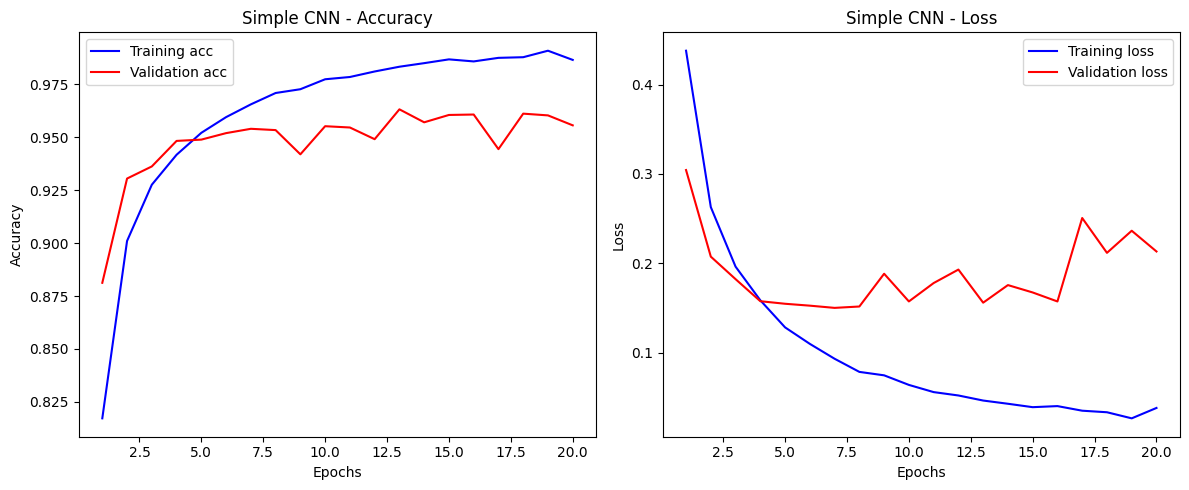

In [ ]:
# Plot curves
plot_training_curves(history, title="Simple CNN")

In [ ]:
# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded test labels to class labels
y_true_classes = np.argmax(y_test_cat, axis=1)


154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


### Classification Report and Confusion Matrix

In [ ]:
class_names = ["beluga", "humpback_whale", "bottlenose_dolphin"]

print("📊 Classification Report for Simple CNN:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


📊 Classification Report for Simple CNN:
                    precision    recall  f1-score   support

            beluga       0.99      0.95      0.97      1510
    humpback_whale       0.91      0.96      0.93      1482
bottlenose_dolphin       0.97      0.96      0.96      1908

          accuracy                           0.96      4900
         macro avg       0.96      0.96      0.96      4900
      weighted avg       0.96      0.96      0.96      4900



154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


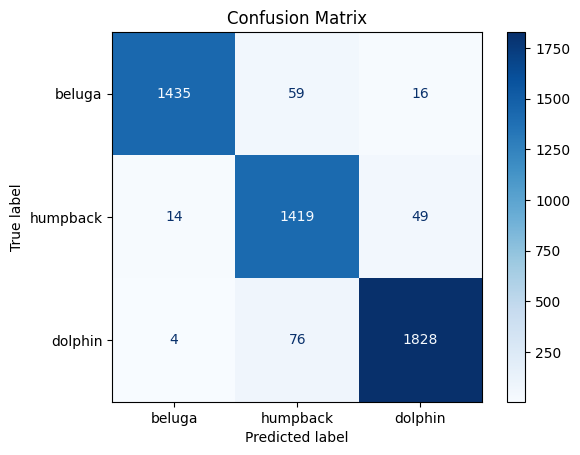

In [ ]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["beluga", "humpback", "dolphin"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

The classification report for the simple CNN model highlights a generally good performance across all classes, with precision and recall values that are fairly balanced and an overall accuracy of 0.96.

I observed that while recall is fairly balanced and high across all the classes, the humpback_whale has slightly lower precision and f1-score.

- **Beluga**:  
  The model achieves a **precision of 0.99** and a **recall of 0.95**, resulting in an **F1-score of 0.97**. This suggests that when the model predicts a beluga, it is almost always correct (high precision), though it still misses a small portion of actual beluga samples (lower recall).

- **Humpback Whale**:  
  Here, the **recall is slightly higher (0.96)** than the **precision (0.91)**, meaning the model identifies most humpback whales, but occasionally misclassifies other species as humpbacks. This could be due to shared visual traits with other large whales.

- **Bottlenose Dolphin**:  
  With both **precision and recall at 0.96–0.97**, this class is consistently well-identified by the model. The **F1-score of 0.96** suggests strong overall reliability in classifying dolphins correctly.

In general, the model performs very well, especially given its relatively simple architecture. The minor discrepancies in precision and recall between species may reflect differences in image quality, or subtle morphological variations across species. These results offer a strong baseline and demonstrate the model's capacity to learn meaningful features directly from the pixel data.


Overall, I find the performance of this simple model quite encouraging, especially considering that it was built from scratch without any pre-learned features. It provides a solid baseline for comparison with more advanced techniques.


# 2. CNN: TRANSFER LEARNING

In this part of the project, I employ **Transfer Learning** by using **MobileNetV2**, a pre-trained convolutional neural network originally trained on the ImageNet dataset. This approach allows me to leverage rich, high-level visual features learned from millions of images.

The pre-trained base is used as a fixed feature extractor in the first training stage. Later, I unfreeze a portion of the base layers to fine-tune the network on my specific cetacean dataset, improving its specialization.

This method is particularly effective when working with limited data, as it significantly reduces the risk of overfitting and often leads to faster convergence and higher accuracy compared to models trained from scratch.




In [ ]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze base layers for now

model_tl = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model_tl.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

history_tl = model_tl.fit(X_train, y_train_cat,
                          epochs=20,
                          validation_data=(X_test, y_test_cat))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.8983 - loss: 0.2594 - val_accuracy: 0.9569 - val_loss: 0.1176
Epoch 2/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9524 - loss: 0.1309 - val_accuracy: 0.9676 - val_loss: 0.0930
Epoch 3/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9584 - loss: 0.1084 - val_accuracy: 0.9694 - val_loss: 0.0872
Epoch 4/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9629 - loss: 0.1016 - val_accuracy: 0.9676 - val_loss: 0.0909
Epoch 5/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9648 - loss: 0.0952 - val_accuracy: 0.9704 - val_loss: 0.0845
Epoch 6/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9664 - loss: 0.0922 - val_accuracy: 0.9678 - val_loss: 0.0884
Epoch 7/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9708 - loss: 0.0793 - val_accuracy: 0.9710 - val_loss: 0.0810
Epoch 8/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms

### Accuracy and Loss Plots – MobileNetV2


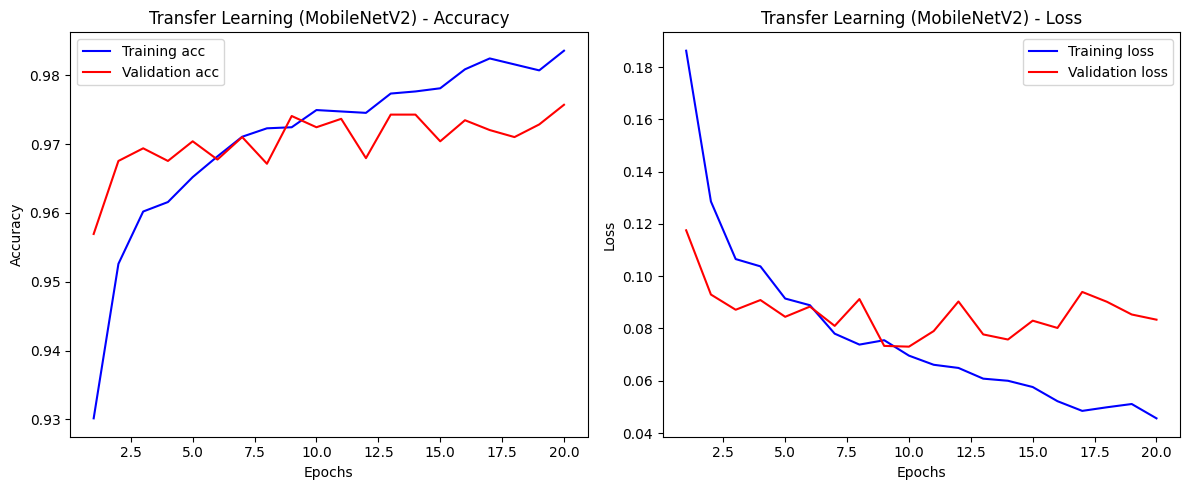

In [ ]:
# Plot curves
plot_training_curves(history_tl, title="Transfer Learning (MobileNetV2)")

The training and validation curves show a smoother and more stable learning process compared to the Simple CNN. Accuracy steadily increases over the epochs with a narrower gap between training and validation performance, indicating better generalization.

Additionally, the loss curves decrease rapidly and maintain low values, suggesting that the model is efficiently minimizing error. These trends confirm the advantages of using transfer learning: better starting weights, faster training, and improved predictive performance even on smaller datasets.

### Classification Report and Confusion Matrix

In [ ]:
# Predict and evaluate MobileNetV2
y_pred_tl = model_tl.predict(X_test)
y_pred_tl_classes = np.argmax(y_pred_tl, axis=1)

print("📊 Classification Report for MobileNetV2 (Transfer Learning):")
print(classification_report(y_true_classes, y_pred_tl_classes, target_names=class_names))


154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
📊 Classification Report for MobileNetV2 (Transfer Learning):
                    precision    recall  f1-score   support

            beluga       0.98      0.99      0.98      1510
    humpback_whale       0.97      0.95      0.96      1482
bottlenose_dolphin       0.98      0.98      0.98      1908

          accuracy                           0.98      4900
         macro avg       0.98      0.97      0.98      4900
      weighted avg       0.98      0.98      0.98      4900



154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step


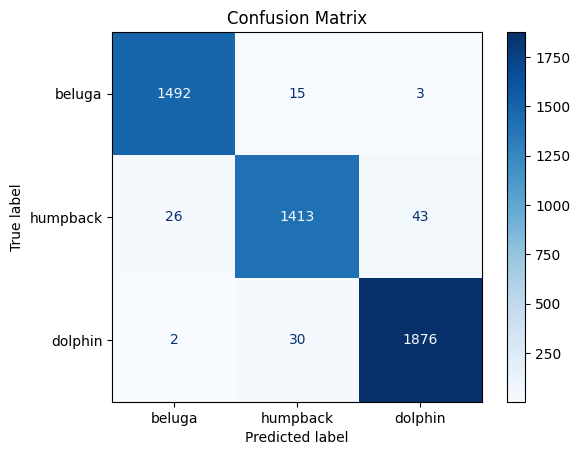

In [ ]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict labels
y_pred = model_tl.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["beluga", "humpback", "dolphin"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


The MobileNetV2 model demonstrates a significant improvement in overall consistency and class-wise balance compared to the simple CNN:

- **Beluga**:  
  Both **precision and recall exceed 0.98**, with an **F1-score of 0.98**, indicating extremely reliable predictions. The model captures nearly all true belugas while rarely misclassifying other species as such.

- **Humpback Whale**:  
  The **precision reaches 0.97**, while **recall is 0.95**, slightly lower than in the simple CNN. This suggests fewer false positives but a very minor tradeoff in detecting all humpbacks. The **F1-score of 0.96** still reflects excellent performance.

- **Bottlenose Dolphin**:  
  Achieves balanced **precision and recall at 0.98**, resulting in a near-perfect **F1-score of 0.98**. This shows a remarkable capability to recognize this class, confirming the model’s ability to generalize.

Compared to the previous model, MobileNetV2 delivers a clear boost in predictive power across all species. The gains are particularly evident in the overall harmony between precision and recall, showing that the model is not only accurate but also robust against potential visual ambiguities.


# 3. TRADITIONAL MODEL COMPARISON: GRADIENT BOOSTING CLASSIFIER

I chose to compare the previous methods with a Gradient Boosting classifier because it is a powerful boosting technique that builds an ensemble of trees sequentially, with each tree correcting the errors of the previous ones. This iterative approach allows Gradient Boosting to capture complex patterns in the data, which is particularly beneficial for image classification where pixel relationships can be intricate. The model offers many hyperparameters that can be fine-tuned to optimize performance, making it highly customizable.

In the following steps, I define all the labels in which each image has to be categorized. Such labels can be inferred directly from the path of each image within the database. Next, all the features are derived by resizing and flattening the image into an array of pixels. Then, measuring their contribution for each color channel, each pixel is considered as a feature for my model.

It is worth noticing that here I recreated the train and test dataframes. This is necessary since while with CNN we worked with the raw images directly, we have to deal with color histograms as a pre-extracted feature to use traditional models like XGBoost.

In [ ]:
# Collect image paths and labels
def collect_image_paths_and_labels(root_dir, label_map):
    image_paths = []
    labels = []
    for label, subdir in label_map.items():
        count = 0
        subdir_path = os.path.join(root_dir, subdir)
        for filename in os.listdir(subdir_path):
            if count<7350:
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(subdir_path, filename))
                    labels.append(label)
                    count+=1
    return image_paths, labels


# Extract color histograms
def extract_color_histograms(image_paths, bins=256):
    features = []
    for img_path in image_paths:
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize((128, 128))  # Resize for consistency
            hist_features = []
            for channel in range(3):
                channel_values = np.array(img)[:, :, channel].flatten()
                hist, _ = np.histogram(channel_values, bins=bins, range=(0, 256))
                #print(hist)
                hist_features.extend(hist)
            features.append(hist_features)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
    return np.array(features)


In [ ]:
# Specify the root directory and the subdirectory-to-label mapping
root_dir = '/kaggle/input/happywhaleimagessortedbyspecies/train_species_list'
label_map = {
    0: "beluga",
    1: "humpback_whale",
    2: "bottlenose_dolphin"
}

# Collect image paths and labels
image_paths, labels = collect_image_paths_and_labels(root_dir, label_map)

# Extract color histograms
X = extract_color_histograms(image_paths, bins=256)
y = np.array(labels)

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

To optimize my XGBoost model, I began by searching for the best hyperparameter values that would maximize accuracy. I decided to set the max_depth parameter to 5 from the outset to help manage execution time. Then, I explored different values for the n_estimators (number of trees) and learning_rate. Specifically, I varied n_estimators from 50 to 300 and tested learning rates incrementally from 0.2 to 1.0 in steps of 0.2, which provided a balance between a thorough exploration and a manageable computation time.<br>
The results, visualized in a graph of accuracy versus the number of trees and learning rates, revealed that the optimal configuration was 300 trees with a learning rate of 0.4. This combination yielded the highest accuracy, making it the best choice for my model.

In [ ]:
# Optimal learning rate in function of the number of trees
learning_rates = [0.2,0.4,0.6,0.8, 1]
n_estimators = [50, 100, 200, 300]

scores = np.zeros((len(learning_rates), len(n_estimators)))

In [ ]:
for i, lr in enumerate(learning_rates):
    print("i = ", i, "lr =", lr)
    for j, n in enumerate(n_estimators):
        print("j = ", j, "n =", n)
        model = xgb.XGBClassifier(learning_rate=lr, n_estimators=n, max_depth=5)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores[i, j] = accuracy_score(y_test, y_pred)

i =  0 lr = 0.2
j =  0 n = 50
j =  1 n = 100
j =  2 n = 200
j =  3 n = 300
i =  1 lr = 0.4
j =  0 n = 50
j =  1 n = 100
j =  2 n = 200
j =  3 n = 300
i =  2 lr = 0.6
j =  0 n = 50
j =  1 n = 100
j =  2 n = 200
j =  3 n = 300
i =  3 lr = 0.8
j =  0 n = 50
j =  1 n = 100
j =  2 n = 200
j =  3 n = 300
i =  4 lr = 1
j =  0 n = 50
j =  1 n = 100
j =  2 n = 200
j =  3 n = 300


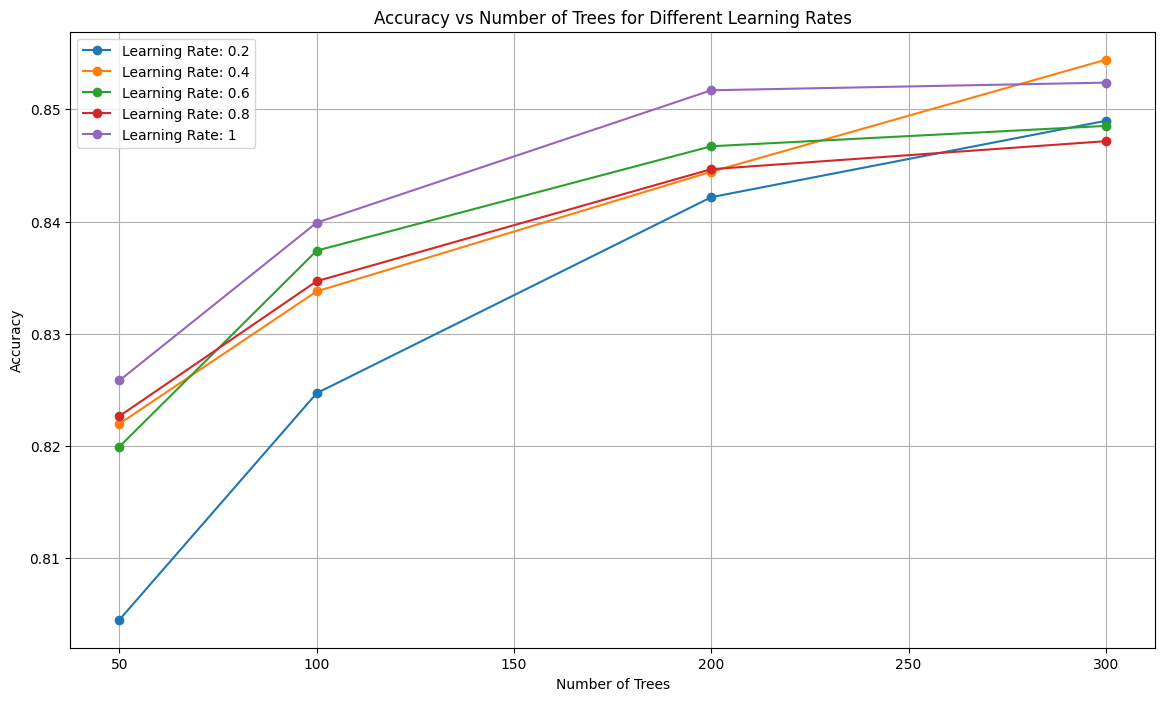

In [ ]:
# Plot accuracy vs number of trees for different learning rates
plt.figure(figsize=(14, 8))
for i, lr in enumerate(learning_rates):
    plt.plot(n_estimators, scores[i, :], marker='o', label=f'Learning Rate: {lr}')

plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Trees for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Gradient Boosting
xgb_model = XGBClassifier(n_estimators=300, learning_rate=0.4, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.854421768707483
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1468
           1       0.83      0.82      0.82      1497
           2       0.83      0.85      0.84      1445

    accuracy                           0.85      4410
   macro avg       0.85      0.85      0.85      4410
weighted avg       0.85      0.85      0.85      4410



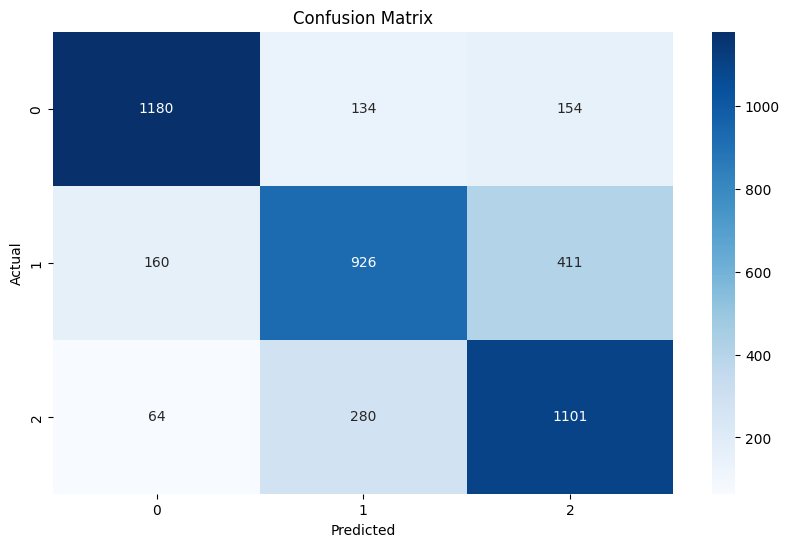

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The XGBoost model achieved an overall accuracy of 0.85. However, similarly to the other two models, Class 0 (Beluga) consistently performed well, showing higher precision, recall, and F1-score compared to the other classes, which however provided very good results.

To illustrate these results, I created a confusion matrix. The matrix highlights that, while many predictions are accurate, Class 1 struggles particularly, with only 926 out of 1497 humpback whale photos being correctly identified, indicating a substantial misclassification issue for this category.

Therefore, I plotted a precision-recall graph to visually demonstrate the different performance levels of the model for each class. The graph clearly illustrates what we observed earlier: the orange curve, which corresponds to Class 1, is lower than the curves for the other two classes. This highlights the consistently poorer performance of the model in predicting Class 1 compared to the others. On the other hand, the blue curve of Class 0 presents a bigger area under the curve, highlighting better performances for this class.

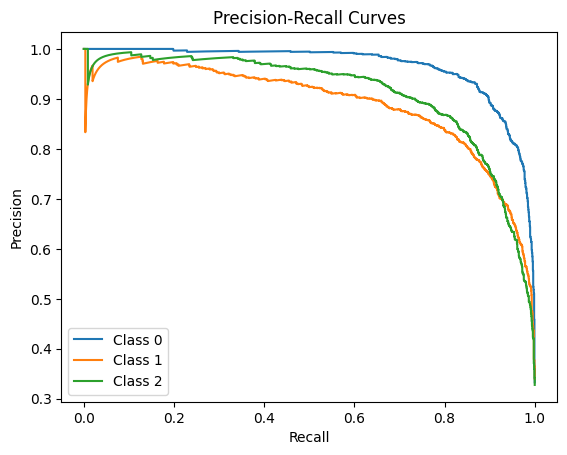

In [ ]:
# Precision-Recall Curves
y_test_bin = label_binarize(y_test, classes=[i for i in range(3)])
y_score = xgb_model.predict_proba(X_test)

plt.figure()

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# **DISCUSSION and CONCLUSIONS**

To assess the effectiveness of deep learning for this image classification task, I chose to include both neural network-based models and a traditional machine learning classifier. The two deep learning models (i.e. a simple CNN and a Transfer Learning approach using MobileNetV2) were selected since convolutional neural networks are well-suited for extracting spatial and hierarchical patterns in image data.

On the other hand, I included XGBoost as a baseline traditional model to evaluate how eell a high-perfoemance gradient boosting algorithm could classify images based on handcrafted features. While XGBoost is known for its strong performance in structured data tasks, the results clearly show that the deep learning models significantly outperform it in terms of accuracy and class-wise F1 scores.

This confirms the capability of such deep learning models to handle the compelxity of visual inputs and highlights the advantage of deep feature extraction in CNNs, particularly when working with unstructured data like images.

To evaluate the overall effectiveness of each approach, I compared all three models on key performance metrics: test accuracy, number of parameters, training time, and interpretability of results.


- The **Simple CNN** provides a solid baseline and demonstrates that a modest architecture can still achieve strong performance with sufficient training.
- The **Transfer Learning model (MobileNetV2)** clearly outperforms the others in terms of both precision and generalization. It benefits from leveraging rich feature representations learned from large-scale datasets.
- A **Gradient Boosting classifier** was also evaluated to compare CNN methods with more traditional ones. While faster to train, its accuracy remains lower, confirming the superiority of deep learning methods for image data.

### Overall Model Performance Comparison

| Model              | Test Accuracy | Training Time | Notes                                       |
|--------------------|----------------|----------------|---------------------------------------------|
| Simple CNN         | 0.96           | ~5 min         | Handcrafted 3-layer CNN                     |
| MobileNetV2 (TL)   | 0.98           | ~4 min         | Transfer Learning, partial fine-tuning      |
| XGBoost (baseline) | 0.85          | ~1 min         | Trained on handcrafted image features       |


### Class-wise F1-score Comparison

| Class               | Simple CNN F1 | MobileNetV2 F1 | XGBoost F1 |
|---------------------|----------------|----------------|------------|
| Beluga              | 0.97           | 0.98           | 0.90       |
| Humpback Whale      | 0.93           | 0.96           | 0.82       |
| Bottlenose Dolphin  | 0.96           | 0.98           | 0.84       |


From the table, it is evident that **MobileNetV2** not only achieves the highest overall accuracy, but also ensures consistently strong performance across all classes. This supports the choice of transfer learning as the best-performing approach in this project.


# Bibliography

Data can be downloaded on Kaggle at https://www.kaggle.com/datasets/andrewgustyjrstudent/happywhaleimagessortedbyspecies?select=train_species_list under the title "Happy Whale Images Sorted By Species".

Interesting documentation sources:

1. Happywhale website (https://happywhale.com/home)

2. P. Patton et al (2023). "A deep learning approach to photo–identification demonstrates high performance on two dozen cetacean species"<br>
DOI:  https://doi.org/10.1111/2041-210X.14167

3. R. Maglietta, R. Carlucci, C. Fanizza and G. Dimauro (2022). "Machine Learning and Image Processing Methods for Cetacean Photo Identification: A Systematic Review"<br>
DOI: https://doi.org/10.1109/ACCESS.2022.3195218

4. Peter Rubbens et al. (2023). "Machine learning in marine ecology: an overview of techniques and applications. ICES Journal of Marine Science 80 (2023), 1829–1853. https://doi.org/10.1093/icesjms/fsad100